## Fragrance Recommendation Models

This project contains 3 different content-based recommendation systems for fragrances based on scents, emotions, and bottle shapes.

Notebook contents:
* Data cleaning
* Data analysis
* Recommendation model based on scent notes
* Recommendation model based on sentiment scores of the descriptions
* Recommendation model based on bottle shapes

The dataset is from [Kaggle](https://www.kaggle.com/datasets/nandini1999/perfume-recommendation-dataset) and was scraped from the fragrance retailer Luckyscent's e-commerce website.

Cleaning notes
* Missing scent notes were collected from respective brand websites where available. If not, descriptions on other retail websites were used.
* Duplicate titles were edited to they can be input into functions.

In [1]:
## Initalising libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import re
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
from skimage import io
import requests
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf

## The data

In [2]:
## Loading the dataset
perfume = pd.read_csv('perfume_data.csv', encoding='unicode_escape')

In [3]:
## Checking the data
perfume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2190 non-null   object
 1   Brand        2190 non-null   object
 2   Description  2190 non-null   object
 3   Notes        2190 non-null   object
 4   Image URL    2190 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB


In [4]:
perfume.head()

,Name,Brand,Description,Notes,Image URL
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, T...","vanilla bean, musk",https://static.luckyscent.com/images/products/...
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending fr...,"lavender, yuzu, lemongrass, magnolia, geranium...",https://static.luckyscent.com/images/products/...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japan...,"green yuzu, green shikuwasa, sansho seed, cori...",https://static.luckyscent.com/images/products/...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where citr...,"tangerine, pink pepper, black coffee, leather,...",https://static.luckyscent.com/images/products/...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate to...,"bergamot, almond, violet, jasmine, leather, sa...",https://static.luckyscent.com/images/products/...


## Data cleaning

In [5]:
## Checking for duplicate rows
duplicates = perfume[perfume.duplicated()]
duplicates

,Name,Brand,Description,Notes,Image URL


In [6]:
## Removing stopwords from Notes
perfume_df = perfume.copy()
stop_words = stopwords.words('english')

## Removing stopwords from Notes
perfume_df['Notes'] = perfume_df['Notes'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## Removing punctuation and making all words lowercase in Description and Notes
perfume_df['Description_clean'] = perfume_df['Description'].apply(lambda x : re.sub("[^a-zA-Z/']", " ", x).lower())
perfume_df['Notes_clean'] = perfume_df['Notes'].apply(lambda x : re.sub("[^a-zA-Z/']", " ", x).lower())

## Removing stopwords from Description_clean
perfume_df['Description_clean'] = perfume_df['Description_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

perfume_df.head()

,Name,Brand,Description,Notes,Image URL,Description_clean,Notes_clean
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, T...","vanilla bean, musk",https://static.luckyscent.com/images/products/...,rapa nui sugar tihota quite simply one one cal...,vanilla bean musk
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending fr...,"lavender, yuzu, lemongrass, magnolia, geranium...",https://static.luckyscent.com/images/products/...,tribute expanse space extending sky flower fru...,lavender yuzu lemongrass magnolia geranium...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japan...,"green yuzu, green shikuwasa, sansho seed, cori...",https://static.luckyscent.com/images/products/...,aromatic ode ancient beauty japan kagiroi repr...,green yuzu green shikuwasa sansho seed cori...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where citr...,"tangerine, pink pepper, black coffee, leather,...",https://static.luckyscent.com/images/products/...,velvet fantasy solar fragrance citrus velvety ...,tangerine pink pepper black coffee leather ...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate to...,"bergamot, almond, violet, jasmine, leather, sa...",https://static.luckyscent.com/images/products/...,there's way lab fire could relocate los angele...,bergamot almond violet jasmine leather sa...


In [7]:
perfume_df.to_csv('perfume_df.csv', index=False)

## Data analysis

### Brands

In [8]:
## Counting number of brands in the dataset
perfume_df['Brand'].nunique()

248

In [9]:
## Finding the most common brands in the dataset
brand_count = perfume_df['Brand'].value_counts().rename_axis('Brand').reset_index(name='Count')
brand_count.head()

,Brand,Count
0,TOM FORD Private Blend,39
1,Profumum,38
2,Serge Lutens,36
3,BYREDO,35
4,Xerjoff,34


In [10]:
## Plotting the most common brands
brand_top_10 = brand_count.iloc[0:10]

x = brand_top_10['Brand']

x_labels=[]
for label in x:
    x_labels.append(label.replace(' ','<br>'))

fig = px.bar(brand_top_10, x='Brand', y='Count', 
             title='Most common brands',
             template= 'plotly_white',
             text_auto='0s',
             color='Brand',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_xaxes(tickvals=x, ticktext=x_labels)
fig.update_traces(textfont_size=12, textposition='outside', cliponaxis=False)
fig.update_layout(showlegend=False)
fig.show()

### Scents

In [57]:
## Finding the most common notes
Counter(' '.join(perfume_df['Notes']).lower().split(','))
print(len(' '.join(perfume_df['Notes']).lower().split(',')))

16920


In [12]:
## Finding the most common notes listed by themselves
lone_note_counter = Counter(' '.join(perfume_df['Notes']).lower().split(',')).most_common()
lone_note_counter = pd.DataFrame(lone_note_counter, columns=['Note', 'Count'])
lone_note_counter.head(10)

,Note,Count
0,patchouli,514
1,sandalwood,470
2,rose,415
3,vanilla,400
4,jasmine,370
5,amber,366
6,musk,362
7,vetiver,328
8,cedar,296
9,bergamot,220


In [13]:
## Plotting the most common lone notes
lone_top_10 = lone_note_counter.iloc[0:10]

fig = px.bar(lone_top_10, x='Count', y='Note', orientation='h', 
             title='Most common notes (lone)',
             template= 'plotly_white',
             text_auto='0s')
fig.update_yaxes(categoryorder='total ascending')
fig.update_traces(marker_color='#CF9FFF', textfont_size=12, textposition="outside", cliponaxis=False)
fig.update_layout(showlegend=False)
fig.show()

In [14]:
## Finding the most common notes listed alone or as part of other notes e.g. musk in white musk
mix_note_counter = Counter(' '.join(perfume_df['Notes_clean']).split()).most_common()
mix_note_counter = pd.DataFrame(mix_note_counter, columns=['Note', 'Count'])
mix_note_counter.head(10)

,Note,Count
0,musk,867
1,rose,714
2,vanilla,695
3,patchouli,626
4,amber,603
5,sandalwood,603
6,bergamot,580
7,jasmine,524
8,vetiver,454
9,cedar,431


In [15]:
## Plotting the most common mixed & lone notes
mix_top_10 = mix_note_counter.iloc[0:10]

fig = px.bar(mix_top_10, x='Count', y='Note', orientation='h', 
             title='Most common notes (lone & mixed)',
             template= 'plotly_white',
             text_auto='0s')
fig.update_yaxes(categoryorder='total ascending')
fig.update_traces(marker_color='#DA70D6', textfont_size=12, textposition="outside", cliponaxis=False)
fig.show()

### Descriptions

In [16]:
from nrclex import NRCLex

sentiments = perfume_df.copy()

def emotion_freq(descriptions):
    res1 = {'anger': 0.0, 'fear': 0.0, 'negative': 0.0, 'positive': 0.0, 'sadness': 0.0, 'trust': 0.0, 'anticipation': 0.0, 'joy': 0.0, 'disgust': 0.0, 'surprise': 0.0}
    descriptions = NRCLex(descriptions)
    freq = descriptions.affect_frequencies
    for k, fq in freq.items():
      res1[k] = res1.get(k, 0.0) + fq
    return res1

sentiments['nrc'] = sentiments['Description_clean'].apply(emotion_freq)
sentiments.head(2)

,Name,Brand,Description,Notes,Image URL,Description_clean,Notes_clean,nrc
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, T...","vanilla bean, musk",https://static.luckyscent.com/images/products/...,rapa nui sugar tihota quite simply one one cal...,vanilla bean musk,"{'anger': 0.024390243902439025, 'fear': 0.0731..."
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending fr...,"lavender, yuzu, lemongrass, magnolia, geranium...",https://static.luckyscent.com/images/products/...,tribute expanse space extending sky flower fru...,lavender yuzu lemongrass magnolia geranium...,"{'anger': 0.0, 'fear': 0.0, 'negative': 0.0476..."


In [17]:
sentiments = pd.concat((sentiments.drop(['nrc'],axis=1), sentiments['nrc'].apply(pd.Series)), axis=1)
sentiments.head(2)

,Name,Brand,Description,Notes,Image URL,Description_clean,Notes_clean,anger,fear,negative,positive,sadness,trust,anticipation,joy,disgust,surprise,anticip
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, T...","vanilla bean, musk",https://static.luckyscent.com/images/products/...,rapa nui sugar tihota quite simply one one cal...,vanilla bean musk,0.02439,0.073171,0.121951,0.268293,0.04878,0.121951,0.121951,0.097561,0.04878,0.073171,0.0
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending fr...,"lavender, yuzu, lemongrass, magnolia, geranium...",https://static.luckyscent.com/images/products/...,tribute expanse space extending sky flower fru...,lavender yuzu lemongrass magnolia geranium...,0.00000,0.000000,0.047619,0.380952,0.00000,0.238095,0.095238,0.190476,0.00000,0.047619,0.0


In [18]:
## Dropping uneccessary columns
sentiments = sentiments.drop('anticip', axis=1)
sentiments.describe()

,anger,fear,negative,positive,sadness,trust,anticipation,joy,disgust,surprise
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,0.035058,0.040063,0.097527,0.303606,0.037332,0.140008,0.110186,0.142871,0.028705,0.064188
std,0.035687,0.043962,0.063542,0.087750,0.037913,0.056170,0.050069,0.053072,0.029999,0.039249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.052632,0.250000,0.000000,0.103448,0.078947,0.109091,0.000000,0.040000
50%,0.028571,0.033333,0.089648,0.297872,0.030303,0.142857,0.107817,0.142857,0.024390,0.062500
75%,0.052632,0.058824,0.130969,0.350877,0.055556,0.173913,0.138889,0.176471,0.045455,0.086957
max,0.250000,1.000000,0.500000,1.000000,0.363636,0.500000,0.500000,0.366667,0.250000,0.333333


In [19]:
## Calculate overall sentiment for each score
anger_total = sum(sentiments['anger'])
fear_total = sum(sentiments['fear'])
neg_total = sum(sentiments['negative'])
pos_total = sum(sentiments['positive'])
sad_total = sum(sentiments['sadness'])
trust_total = sum(sentiments['trust'])
ant_total = sum(sentiments['anticipation'])
joy_total = sum(sentiments['joy'])
disgust_total = sum(sentiments['disgust'])
surprise_total = sum(sentiments['surprise'])

#print the overall sentiments
print('Anger: ', anger_total)
print('Fear: ', fear_total)
print('Negative: ', neg_total)
print('Positive: ', pos_total)
print('Sadness: ', sad_total)
print('Trust: ', trust_total)
print('Anticipation: ', ant_total)
print('Joy: ', joy_total)
print('Disgust: ', disgust_total)
print('Surprise: ', surprise_total)

Anger:  76.77776356001823
Fear:  87.73832313017337
Negative:  213.5830891223233
Positive:  664.8973923618083
Sadness:  81.7565984959553
Trust:  306.6182172530482
Anticipation:  241.306911940386
Joy:  312.88651207570547
Disgust:  62.862942099500735
Surprise:  140.57224996108042


In [20]:
## Plotting the sentiment totals

sent_totals = [['Anger', 76.77163226134492], ['Fear', 87.72974277495436], ['Negative', 213.5639165545107], ['Positive', 664.8559181000388], ['Sadness', 81.74491329555934], 
               ['Trust', 306.6270424227923], ['Anticipation', 241.4132082645837], ['Joy', 312.87162776165593], ['Disgust', 62.858463384937984], ['Surprise', 140.56353517962128]]

sent_totals_df = pd.DataFrame(sent_totals, columns=['Sentiment', 'Total'])

fig = px.bar(sent_totals_df, x='Sentiment', y='Total', 
             title='Total sentiment scores',
             template= 'plotly_white',
             text_auto='0s',
             color='Sentiment',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_traces(textfont_size=12, textposition='outside', cliponaxis=False)
fig.update_layout(showlegend=False)
fig.show()

## Recommendation Models

### Scents

Content-based recommendation system based on scent notes

In [21]:
## Construct TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(perfume_df['Notes_clean'])
tfidf_matrix.shape

(2190, 1416)

In [22]:
## Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(2190, 2190)

In [23]:
## Create a reverse map of indices and perfume names
indices = pd.Series(perfume_df.index, index=perfume_df['Name']).drop_duplicates()
indices

Name
Tihota Eau de Parfum                      0
Sola Parfum                               1
Kagiroi Parfum                            2
Velvet Fantasy Eau de Parfum              3
A Blvd. Called Sunset Eau de Parfum       4
                                       ... 
Perfect Veil Eau de Parfum             2185
Scent Eau de Parfum                    2186
Bronze Eau de Parfum                   2187
Monyette Paris Fragrance Oil           2188
1270 Eau de Parfum                     2189
Length: 2190, dtype: int64

In [24]:
## Function that outputs most similar perfumes in terms of notes

def scent_recommendations(name, cosine_sim=cosine_sim):
    idx = indices[name]
    print('Selected fragrance:', perfume_df['Name'].iloc[idx])
    print('Notes:', perfume_df['Notes'].iloc[idx])
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    perfume_indices = [i[0] for i in sim_scores]

    return perfume_df[['Name', 'Brand', 'Notes']].iloc[perfume_indices]

scent_recommendations('Interlude Black Iris Eau de Parfum')

Selected fragrance: Interlude Black Iris Eau de Parfum
Notes: bergamot, rosemary, violet leaves, orris, amber, frankincense, cistus, myrrh, vanilla, leather, agarwood smoke, patchouli, sandalwood, cedar


,Name,Brand,Notes
1780,Interlude Man Eau de Parfum,Amouage,"bergamot, oregano, pimento berry oil, amber, f..."
920,Nudiflorum Extrait de Parfum,Nasomatto,"jasmine, smoke, bergamot"
1400,Black Prestigium Eau de Parfum,Mancera,"bergamot, orris, spices, patchouli, rose, viol..."
1459,Herod Eau de Parfum,Parfums de Marly,"cinnamon, pepperwood, osmanthus, tobacco leave..."
1028,Eau My Soul Eau de Parfum,4160 Tuesdays,"bergamot, lavender, honey, frankincense, cogna..."


### Sentiments

Content-based filtering system based on sentiment scores

In [25]:
## Select data for recommendation system
sentiments_table = sentiments.copy()
sentiments_table.set_index('Name', inplace=True)

In [26]:
## Creating sentiment score matrix
sentiments_df = sentiments_table.iloc[:, 6:16]
sentiments_df.head()

,anger,fear,negative,positive,sadness,trust,anticipation,joy,disgust,surprise
Name,,,,,,,,,,
Tihota Eau de Parfum,0.024390,0.073171,0.121951,0.268293,0.048780,0.121951,0.121951,0.097561,0.04878,0.073171
Sola Parfum,0.000000,0.000000,0.047619,0.380952,0.000000,0.238095,0.095238,0.190476,0.00000,0.047619
Kagiroi Parfum,0.000000,0.019608,0.019608,0.274510,0.000000,0.137255,0.274510,0.156863,0.00000,0.117647
Velvet Fantasy Eau de Parfum,0.027778,0.000000,0.055556,0.277778,0.000000,0.166667,0.166667,0.194444,0.00000,0.111111
A Blvd. Called Sunset Eau de Parfum,0.000000,0.041667,0.083333,0.333333,0.020833,0.125000,0.187500,0.125000,0.00000,0.083333


In [27]:
## Map of indices and perfume names
sent_indices = pd.Series(perfume_df.index, index=perfume_df['Name']).drop_duplicates()

In [28]:
## Function that outputs most similar perfumes in terms of sentiment scores
def sentiment_recommendations(name):
    idx = sent_indices[name]
    print('Selected fragrance:', perfume_df['Name'].iloc[idx])
    print('Description:', perfume_df['Description'].iloc[idx])
    knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors=6)
    knn_model.fit(sentiments_df.values)
    distances, indices = knn_model.kneighbors(sentiments_df.iloc[idx,:].values.reshape(1,-1))
    perfume_indices = indices.flatten()
    perfume_indices = perfume_indices[1:6]

    return perfume_df[['Name', 'Brand', 'Description']].iloc[perfume_indices]

sentiment_recommendations('The Soft Lawn Eau de Parfum')

Selected fragrance: The Soft Lawn Eau de Parfum
Description: "They hopped the fence of the Governor's Mansion, laid side by side on the cool grass tennis court, and invented constellations until the sunrise usurped their astral empire." - Claude LeCoq.
Claude LeCoq published his first book, The Soft Lawn, in 1916 while still attending Princeton University. A controversial portrait of adolescent upper-class rebellion in New England, the coming-of-age story follows Hampton Perry, a charmingly snotty college tennis champ who, after years of having everything handed to him on a silver platter, finds himself handing it all back.
Like a spring breeze, light as musk, with verdant leaves, laurel, and sweetly clean linden blossom. A great leisure fragrance, wear The Soft Lawn on weekends or anytime you wish it were the weekend.


,Name,Brand,Description
372,Jupiter Eau de Parfum,Electimuss,"Jupiter, the King of the Gods was revered and ..."
1252,Eau Sacree Extrait de Parfum,HEELEY,"Since ancient days, disparate societies separa..."
1539,Red Hoba Eau de Parfum,Xerjoff,A fragrance doesn't necessarily have to be a g...
101,Whisky Oud Parfum Concentration,Farmacia SS. Annunziata dal 1561,"Rich, smooth, and indulgent, Whisky Oud is the..."
1141,Yesterday Haze Eau de Parfum,Imaginary Authors,"""Just as sunsets are more beautiful on hazy da..."


### Shape

Visual similarity recommendation system based on a pre-trained CNN model

In [44]:
## Load pre-trained model
vgg_model = vgg16.VGG16(weights='imagenet')

## Remove the last layers to get features rather than predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)

## Print the layers of the CNN
feat_extractor.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
## Setting up parameters
img_width, img_height = 224, 224
nb_closest_images = 5

In [48]:
## Read images from urls in dataframe
image_data = []
for index, row in perfume_df.iterrows():
    try:
        img = Image.open(BytesIO(requests.get(row['Image URL']).content)).resize((224, 224), Image.LANCZOS)
        image_data.append(np.array(img))
    except Exception:
        print('Error in Fetching Image_URL_1 = ',row['Image URL'],' lot = ',row['LOT_NUMBER'])
        pass

In [49]:
## Convert the image data to batch format: batchsize, height, width, channels
image_data = tf.expand_dims(image_data, 0)

In [33]:
## Check the batch
image_data

'\nimage_data\n'

In [50]:
## Run images through the model
test = image_data[0] ## Make correct batch shape
test_features = feat_extractor.predict(test)

69/69 [==============================] - 194s 3s/step


In [51]:
## Check
test_features.shape

(2190, 4096)

In [52]:
## Find cosine similarities between images
c_sim = cosine_similarity(test_features)

In [53]:
## Create dataframe
csim_df = pd.DataFrame(c_sim)
csim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189
0,1.000000,0.712694,0.694492,0.485039,0.536689,0.518352,0.759290,0.631988,0.642625,0.634059,...,0.724108,0.662569,0.564691,0.661621,0.646562,0.704002,0.588416,0.778707,0.686144,0.709901
1,0.712694,1.000000,0.888030,0.373625,0.523193,0.524732,0.603447,0.571167,0.570765,0.570900,...,0.574460,0.556403,0.570494,0.622626,0.568994,0.548884,0.462938,0.625635,0.676712,0.618497
2,0.694492,0.888030,1.000000,0.369850,0.588276,0.562167,0.633379,0.612950,0.622581,0.595263,...,0.665634,0.585724,0.547585,0.656407,0.568912,0.623814,0.532682,0.656306,0.645027,0.618026
3,0.485039,0.373625,0.369850,1.000000,0.639339,0.628186,0.454868,0.534151,0.515717,0.543208,...,0.494299,0.624494,0.666384,0.606441,0.643698,0.585232,0.485408,0.492272,0.610301,0.532372
4,0.536689,0.523193,0.588276,0.639339,1.000000,0.951260,0.553535,0.656035,0.635053,0.631352,...,0.640709,0.758619,0.687832,0.828399,0.746277,0.752836,0.602649,0.591855,0.655084,0.643137


In [55]:
## Map indices to original dataframe
shape_indices = pd.Series(csim_df.index, index=perfume_df['Name']).drop_duplicates()

Selected perfume


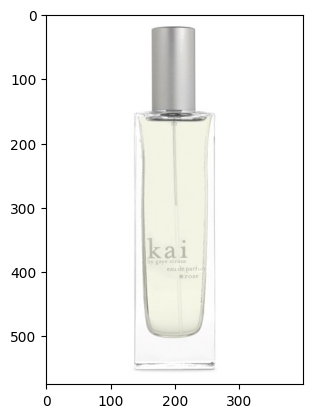

Similar bottles


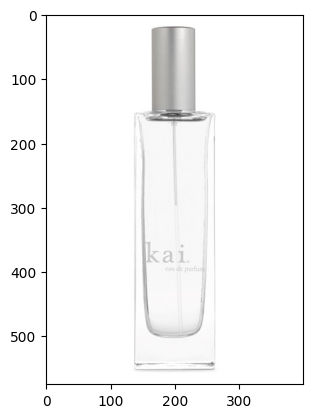

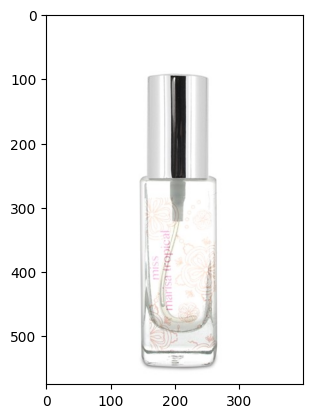

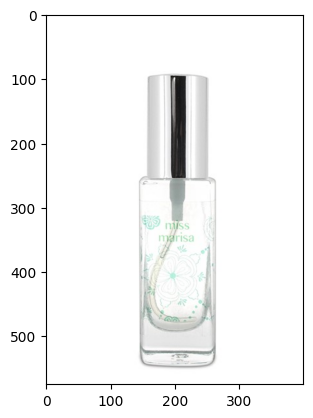

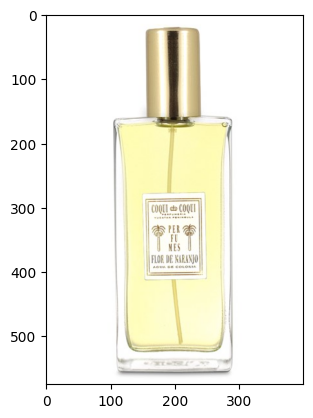

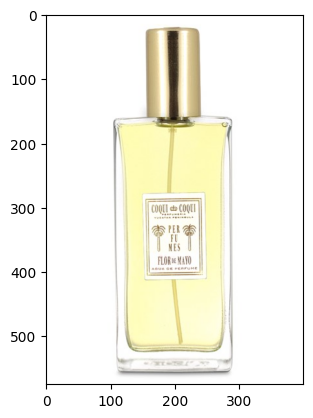

,Name,Brand,Notes
2111,Kai - Eau de Parfum Eau de Parfum Spray,Kai,notes gardenia white exotic florals
2099,Miss Marisa Tropical perfume spray Eau de Parfum,Ebba,"mango, coconut, ginger, peach, waterlilly, casis"
2098,Miss Marisa perfume spray Eau de Parfum,Ebba,"plum blossom, cassis, fresh mint, waterlily"
1315,Flor de Naranjo Eau de Parfum,Coqui Coqui,orange blossom
1309,Floplum (Flor de Mayo) Eau de Parfum,Coqui Coqui,"plumeria, jasmine"


In [56]:
## Function that outputs most similar perfumes in terms of bottle shape
def shape_recommendations(name):

    idx = shape_indices[name]

    print('Selected perfume')
    input_image = io.imread(perfume_df['Image URL'].loc[idx])
    plt.imshow(input_image)
    plt.show()

    closest_shapes = csim_df.loc[idx].sort_values(ascending=False)[1:nb_closest_images+1].index
    get_numbers = [float(i) for i in closest_shapes]
    print('Similar bottles')

    for i in get_numbers:
        output_images = io.imread(perfume_df['Image URL'].loc[i])
        plt.imshow(output_images)
        plt.show()
    return perfume_df[['Name', 'Brand', 'Notes']].iloc[closest_shapes]

shape_recommendations('Kai Rose - Eau de Parfum Eau de Parfum Spray')